# Pulling in Libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.feature_extraction import text
from sklearn.metrics.pairwise import cosine_similarity
from pylab import rcParams
rcParams['figure.figsize'] = 50, 20
import nltk
from nltk.corpus import stopwords
import re
import time
start=time.time()
nltk.download('stopwords')
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/coreyyoung/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# Functions to clean skills data and make a vocabulary for skills vectorization

def text_scrubber(values):
    
    '''
        Replace problematic phrases and unicode characters.
        
        (10+ years) ---> ''
        &#39; , \x92 ---> apostrophe
        Technical: ---> ''
        
        These characters act usually as separators, so replace them with commas for splitting later.
            [:, ;, &amp;, \x95, &, ., /, 'and'] ---> ','
        
    '''

    result = []
    for string in values:
        # Regex as explained above
        temp = re.sub('(\(.*\))', '', string)
        temp = re.sub('&#39;|\x92', '\'', temp)
        temp = re.sub(' &amp; |&amp;|\x95|:|;|&|\.|/| and ', ',', temp)
        temp = re.sub('\w*:\s+', ', ', temp)
        
        result.append(temp)
        
    return result



def tokenizer(df):
    
    
    '''
        Parse the given skills dataframe to pull out appropriate skill phrases.
        Dataframe has some cells that are 2-gram nicely made skills, and other cells
        that are long runons with many skills.
        After scrubbing and then splitting on commas, we simplify the task by tossing
        out any greater than 4-gram phrases. 
    '''
    
    # Custom stop words that come up very often but don't say much about the job title.
    stops = ['manager', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily',
             'services', 'job', 'using', '.com', 'end', 'prepare', 'prepared', 'lead', 'requirements','#39'] + list(stopwords.words('english'))
    values, ids, resume_ids = [],[],[]
    count = 0
    for idx, row in df.iterrows():
        
        # Split on commas
        array = row['skills'].lower().split(',')
        for x in array:
            # make sure the value is not empty or all numeric values or in the stop words list
            if x != '' and not x.lstrip().rstrip() in stops and not x.lstrip().rstrip().isdigit():
                # make sure single character results are the letter 'C' (programming language)
                if len(x) > 1 or x == 'C':
                    # drop stuff > 4 gram
                    if len(x.split(' ')) <= 4:
                        # update lists
                        
                        values.append(x.lstrip().rstrip())
                        ids.append(count)
                        count+=1
    
    # New dataframe with updated values.
    result_df = pd.DataFrame()
    
    result_df['skills'] = values
    return result_df

df = sample2.copy()

df['skills'] = text_scrubber(df['skills'])
test_df = tokenizer(df)

voc = test_df['skills'].unique()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:53: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


# Vectorizing job descriptions and skills for features

In [11]:
# Vectorize text of job descriptions, put resulting matrix into dataframe
sample2['description'] = [x.replace("&nbsp;"," ").replace("\x92"," ").replace("\x95"," ").replace('&amp;'," ") \
                             .replace('*'," ").replace("."," ").replace("co&#39;s","").replace("\xae&quot;","") \
                             .replace("&#39;s","").replace("&quot;","").replace("?","").replace("&#39;s","") \
                             .replace("@","").replace("\x96","")
                             for x in sample2['description']]

mine = ['manager', 'amp', 'nbsp', 'responsibilities', 'used', 'skills', 'duties', 'work', 'worked', 'daily',
       'services', 'job', 'using', 'com', 'end', 'prepare', 'prepared', 'lead', 'requirements']
vec = TfidfVectorizer(analyzer='word', ngram_range=(1,2), token_pattern='[a-zA-z]{3,50}', max_df=0.2, min_df=2,
                      max_features=10000, stop_words=text.ENGLISH_STOP_WORDS.union(mine), decode_error='ignore', vocabulary=None, binary=False)

description_matrix2 = vec.fit_transform(sample2['skills']+sample2['description'])
description_matrix2 = pd.DataFrame(description_matrix2.todense())
description_matrix2.columns = vec.get_feature_names()

In [12]:
# Vectorize skills text with scrubby as vocab, put resulting matrix into dataframe
vec2 = TfidfVectorizer(vocabulary=voc, decode_error='ignore')
skills_matrix2 = vec2.fit_transform(sample2['skills']+sample2['description'])
skills_matrix2 = pd.DataFrame(skills_matrix2.todense())
skills_matrix2.columns = vec2.get_feature_names()



In [13]:
# Combine skills and description matrices into combined job title feature matrix

jobtitle_matrix = pd.concat([skills_matrix2, description_matrix2], axis=1)

# Run PCA to reduce number of features for clustering, logistic regression, and cosine similarity calculations
Ideally, this would run on a scheduled basis as more data came in to train the model

In [16]:
# Run PCA to reduce number of features

pca = PCA(n_components=1000, random_state=42)
comps = pca.fit_transform(jobtitle_matrix)

In [17]:
# Put the components into a dataframe

comps = pd.DataFrame(comps)

# Cluster data into similar titles to increase efficiency of cosine similarity calculations

In [18]:
# Cluster job titles based on components derived from feature matrix

cltr = AgglomerativeClustering(n_clusters=8)
cltr.fit(comps)

# Add new column containing cluster number to sample, comps, and feature matrix dataframes

sample2['cluster_no'] = cltr.labels_

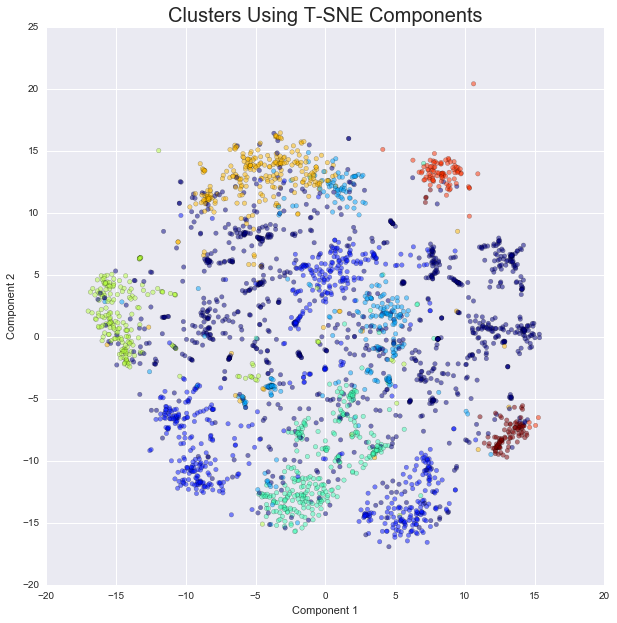

In [19]:
# Look at clusters

from sklearn.manifold import TSNE

tsne = TSNE()
g = pd.DataFrame(tsne.fit_transform(comps), columns=['one', 'two'])


g['cluster_no'] = cltr.labels_

import matplotlib.cm as cm

plt.figure(figsize=(10,10))
plt.title('Clusters Using T-SNE Components', fontsize=20)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.scatter(g['one'], g['two'], c=g['cluster_no'], cmap=cm.jet, alpha=0.5)

plt.show()

# Train multinomial logistic regression to assign clusters to incoming users

In [20]:
# Assign X, y, and the train test split
X = comps
y = sample2['cluster_no']

In [21]:
# Test logistic regression
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)
lr = LogisticRegression(C=10, penalty='l2', multi_class='multinomial', solver='sag', max_iter=1000)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.86538461538461542

In [22]:
# Fit logistic regression to entire data
lr.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
# Assign cluster number to each job title in comps to pull particular cluster out for comparison
comps['cluster_no'] = y.values
comps.set_index('cluster_no', inplace=True)

# Suggest jobs and skills based on user resume text

In [43]:
resume_text = '''MattBrownám.brown3255@gmail.com½mattbrownblog.tumblr.com/§6308065959XSeattle,Washingtonâ/in/mattbrown3255brownmt3255SUMMARYI am a business intelligence professional with a passion for using data to make faster and betterdecisions that leads to improved customer experiences and increased productivity. My combination oftechnical and business experience provides a unique skill-set to be able to work cross-functionally toachieve these results.SKILLSTECHNICAL:SQL (MySQL), Python (Pandas, Scikit-Learn, NumPy, Seaborn), NoSQL (MongoDB), Big Data (AWS, Hadoop, Spark), Tableau,Advanced Microsoft Excel (Power BI, Macros, etc.)BUSINESS:E-Commerce, Online Marketing, Negotations, Inventory Management/Supply Chain Optimization, Prot and Loss ManagementEXPERIENCEGeneralAssembly·Student- DataScienceImmersiveSeattle,WA·Oct2016 - Learned the skills to become a data professional including Python (Pandas, Numpy, Seaborn, Scikit-Learn), Advanced SQL,  No-SQL (MongoDB), MachineLearning Modeling , Big Data (AWS, Hadoop, Spark), and Tableau.- Completed a blog, 6 weekly projects, and 1 capstone project that utilizes each part of the data science workow.- Built a website that hosts a Tableau dashboard of my Halo 5 (video game) statistics connected via public API.- Created a Data Science "Toolbelt" iPython notebook that is utilized by other classmates for various coursework.Amazon·BrandSpecialist- VideoGames,ShoesSeattle,WA·Feb2014toOct2016- Responsible for execution and strategy of the Microsoft (Xbox, Halo, etc) business in Video Games. Previously was on the Rockport shoes account untilJune 2015.- Main responsibilities were marketing/site experiences, inventory management/supply chain, and digital selection/CX improvements.- Subject Matter Expert for catalog item data accuracy/automation, perfect inbound, and category wide reporting in shoes.- Revamped the Amazon.com/Halo brand store by making it mobile friendly and added two widgets to allow customers to nd all categories of Haloproducts (games, toys, clothing, etc).- Created rst marketing/social media e-sports partnership with the Halo Championship Series streamed live on Twitch and mirrored onAmazon.com/Halo.Target·SeniorBusinessAnalyst- Target.comMinneapolis,MN·Jun2012toFeb2014- Managed $50M+ worth of inventory ow and instocks for Entertainment (Movies, Music, and Books) and Girls Toys for Target.com.  - Invented new process and analytics suite to predict store new release sales using online real-time web analytics metrics resulting in increased buys on keynew release titles and the SVP and VP Multichannel Merchandising Awards.-  Created and trained Target.com merchandising team on web analytics suite Adobe Site Catalyst (Omniture) .MyCampusCakes.Com·Co-FounderBloomington,IN·Feb2011toJun2012- Co-founded MyCampusCakes.Com with my college roommate while at Indiana University.- MyCampusCakes.com was a website/service that allowed parents of students at Indiana University to send their student a birthday cake/cupcakes,balloons/utensils, and a card/note to their door.KelleySchoolofBusiness·X201TechnologyinBusiness:TeachingAssistantBloomington,IN·Dec2010toMay2012- Selected by faculty and other teaching assistants to guide 30+ students on in-class Excel projects and coursework. - Held weekly oce hours to help 20+ students on course material.SearsHoldingsCorporation·BuyerApprenticeIntern- OnlineConsumerElectronicsHoffmanEstates,IL·May2011toAug2011- Shadowed the buying team on site merchandising, inventory management, and vendor negotiations.- Built an Excel tool/dashboard to identify assortment gaps.Dataium·SummerAnalystNashville,TN·May2010toAug2010- Dataium is a big data web analytics startup for the automotive industry (sold to IHS, NYSE).- Learned the ins and outs of web analytics including cookie-gathering, click maps, and click analytics of over 4 million unique users. EDUCATIONIndianaUniversityBloomingtonBachelor of Science in Business Marketing & Operations 2012GeneralAssemblyData Science Immersive 2016Three month full-time in-person course that teaches the skills to to become a data professional including Python (Pandas, Numpy, Seaborn, Scikit-Learn),Advanced SQL, No-SQL (MongoDB), Machine Learning Modeling (Regression, Classication, Clustering) , Big Data (AWS, Hadoop, Spark), and Tableau.OnlineLearningTeamTreeHouse.com: Learn Python | Advanced SQL | MySQL Database FoundationsUdemy.com: Python for Data Science & Machine Learning BootcampCodecademy.com: Python | Advanced SQLPROJECTSHalo5Tableau DashboardI created a Tableau Dashboard for my personal Halo 5 (video game) stats. I've always wanted to be able to easily lter by a time-frame and see the mostimportant statistics from my games. I created this by plugging into the Halo 5 Public API (https://developer.haloapi.com), data munging with Python, andfeeding into Tableau Online Server.AWARDSTargetCorporation·SVPMultichannelMerchandisingAwardSep2013Utilized site analytics and pre-orders to predict store sales resulting in increased buys on key entertainment titles that ended up over-performing in storesduring its street week sales.
'''

In [44]:

def give_suggestions(resume_text):
    # Vectorize user's skills and job descriptions
    desc = pd.DataFrame(vec.transform([resume_text]).todense())
    desc.columns = vec.get_feature_names()
    skillz = pd.DataFrame(vec2.transform([resume_text]).todense())
    skillz.columns = vec2.get_feature_names()
    mat = pd.concat([skillz, desc], axis=1)

    # Tranform feature matrix with pca
    user_comps = pd.DataFrame(pca.transform(mat))

    # Predict cluster for user and print cluster number
    cluster = lr.predict(user_comps)[0]
    print 'CLUSTER NUMBER', cluster, '\n\n'

    # Calculate cosine similarity
    cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==cluster]))

    # Get job titles from sample2 to associate cosine similarity scores with jobs
    samp_for_cluster = sample2[sample2['cluster_no']==cluster]
    cos_sim = cos_sim.T.set_index(samp_for_cluster.index)
    cos_sim.columns = ['score']

    # Print the top ten suggested jobs for the user's cluster
    print 'Top ten suggested for your cluster', '\n', cos_sim.sort_values('score', ascending=False)[:10], '\n\n'

    # Print the top five suggested jobs for each cluster
    mat = mat.T
    for i in range(8):
        cos_sim = pd.DataFrame(cosine_similarity(user_comps,comps[comps.index==i]))
        samp_for_cluster = sample2[sample2['cluster_no']==i]
        cos_sim = cos_sim.T.set_index(samp_for_cluster.index)
        cos_sim.columns = ['score']
        top_5 = cos_sim.sort_values('score', ascending=False)[:5]

        # Merge top_5 with sample2 to get skills and description
        merged_top_5 = top_5.merge(sample2, how='left', left_index=True, right_index=True)
        print '---------Top five suggested in cluster', i,  '---------\n', top_5, '\n\n'
        # Vectorize to find skills needed for each job title

        for job in merged_top_5.index:
            job_skills = pd.DataFrame(vec2.transform([merged_top_5.ix[job]['description']+merged_top_5.ix[job]['skills']]).todense())
            job_skills.columns = vec2.get_feature_names()
            job_skills = job_skills.T
            job_skills.columns = ['score']
            job_skills = job_skills[job_skills['score'] != 0].sort_values('score', ascending=False)
            mat.columns = ['score']
            mat = mat[mat['score'] != 0]
            needed_skills = []
            scorey = []
            for i in job_skills.index:
                if i not in mat.index:    
                    needed_skills.append(i)
                    scorey.append(job_skills.ix[i][0])
            top_skills = pd.DataFrame(zip(needed_skills, scorey), columns=['Skills', 'Importance'])
            print 'To become a/an', job+',', '\n', 'these are the top ten skills you need:', '\n'
            print top_skills[:10], '\n'
        
            
        
    

In [45]:
give_suggestions(resume_text)

CLUSTER NUMBER 0 


Top ten suggested for your cluster 
                                                       score
title                                                       
senior product marketing manager - advertising/...  0.313398
business data analyst                               0.274389
product management consultant                       0.212818
senior software engineer (cloud platform engine...  0.211558
assistant professor                                 0.201595
surveyor                                            0.194594
senior marketing research analyst                   0.191307
research                                            0.186380
student assistant                                   0.184194
graduate research assistant                         0.177822 


---------Top five suggested in cluster 0 ---------
                                                       score
title                                                       
senior product marketing manager - a